# Disseration Experiment 6a
# Generate DICE Output (Credit Default) October Sixteen¶
Ciaran Finnegan October 2023

In [1]:
# Import libs
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
import shap
import random

# Display libraries
from IPython.display import display, HTML
from prettytable import PrettyTable

# Import necessary libraries for LIME calculations
import lime
import lime.lime_tabular

# Import necessary library for ANCHOR explainer
from alibi.explainers import AnchorTabular

# Import necessary library for DICE explainer
import dice_ml
from dice_ml.utils import helpers  # helper functions

# Libraries required for metrics calculations
from scipy.spatial import distance
from sklearn.cluster import KMeans

from sklearn.preprocessing import LabelEncoder
import warnings
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample


# Classifier training (not used for explainability)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Data Visualisation and Exploration

## Import Data

In [2]:
ds_file_to_load = 'credit_default_data.csv'
df = pd.read_csv(ds_file_to_load)

## Data Exploration

In [3]:
def styled_dataframe(df):
    styles = {
        'selector': 'table',
        'props': [('background-color', '#f4f4f4'),
                  ('color', '#000000'),
                  ('border-color', '#e0e0e0'),
                  ('border', '1px solid #e0e0e0'),
                  ('font-family', 'Arial, sans-serif'),
                  ('width', '100%')]
    }
    
    # Apply the styles to the dataframe
    styled_df = (df.style.set_table_styles([styles])
                 .set_properties(subset=df.columns, **{'min-width': '5000px', 'text-align': 'center'})
                 .format(None, na_rep='NA'))
    
    # Convert styled dataframe to HTML and wrap in a div container for scrolling
    styled_html = f'<div style="width:100%; overflow-x:auto;">{styled_df.render()}</div>'
    
    return display(HTML(styled_html))

# To check the function (using a sample dataframe)
sample_df = pd.DataFrame({
    'A': [1, 2, 3, 4, 5],
    'B': [5, 6, 7, 8, 9],
    'C': [1, 2, 3, 4, 5],
    'D': [5, 6, 7, 8, 9],
    'E': [1, 2, 3, 4, 5]
})
styled_dataframe(sample_df)


this method is deprecated in favour of `Styler.to_html()`


,A,B,C,D,E
0,1,5,1,5,1
1,2,6,2,6,2
2,3,7,3,7,3
3,4,8,4,8,4
4,5,9,5,9,5


### Dataset Structure

In [4]:
# Display the first few rows of the dataset to understand its structure
#df.head()
#print(df.head().to_string())
styled_dataframe(df.head())

this method is deprecated in favour of `Styler.to_html()`


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
# Reset default Pandas display options
pd.reset_option('display.max_columns')
pd.reset_option('display.expand_frame_repr')
pd.reset_option('display.max_colwidth')
# Display the dataframe
display(df.head())

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
# Display the dataframe as plain text to bypass any CSS/HTML styles
print(df.head().to_string())

   LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default
0      20000    2          2         1   24      2      2     -1     -1     -2     -2       3913       3102        689          0          0          0         0       689         0         0         0         0        1
1     120000    2          2         2   26     -1      2      0      0      0      2       2682       1725       2682       3272       3455       3261         0      1000      1000      1000         0      2000        1
2      90000    2          2         2   34      0      0      0      0      0      0      29239      14027      13559      14331      14948      15549      1518      1500      1000      1000      1000      5000        0
3      50000    2          2         1   37      0      0      0      0      0      0      46990      48233      492

### Generate Visualizations

In [7]:
# Set up the target and features to be visualised

sTarget_feature = 'default'
sFeature_analysis_1 = 'LIMIT_BAL'
sFeature_analysis_2 = 'AGE'
sFeature_analysis_3 = 'SEX'
sFeature3_ticklabel1 = 'Male'
sFeature3_ticklabel2 = 'Female'

In [8]:
# Generate Visualizations to better understand the data distribution and relationships between features.

#### Bar and Box Plot Visualisations

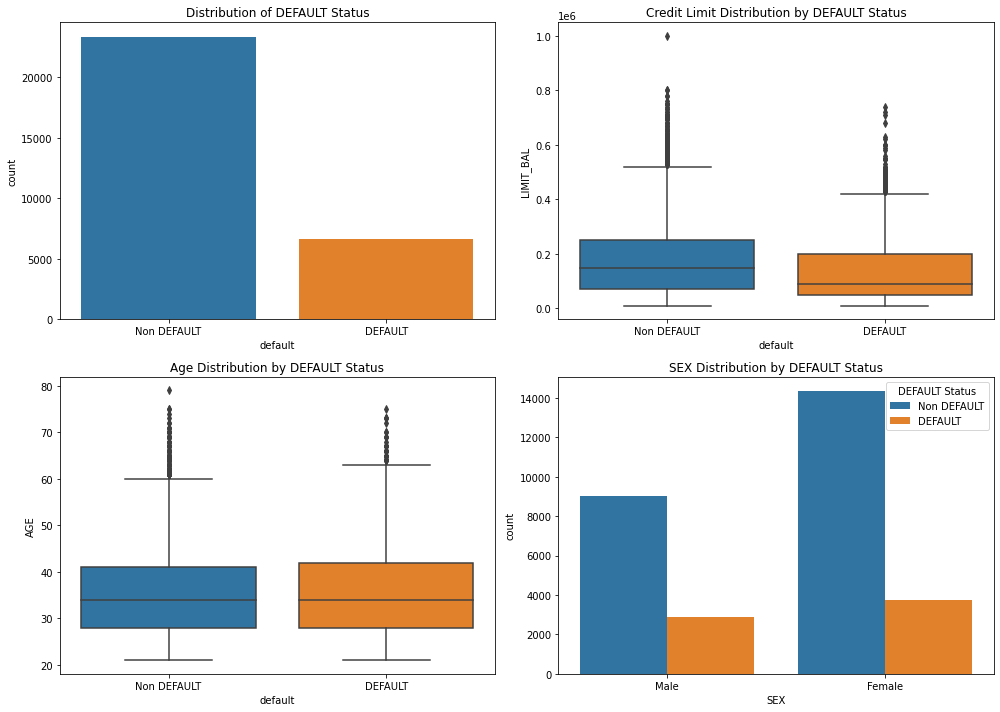

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure and axes
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Plot distribution of the dataset target variable
sns.countplot(data=df, x=sTarget_feature, ax=ax[0, 0])
sPlot_title1 = 'Distribution of ' + sTarget_feature.upper() + ' Status'
ax[0, 0].set_title(sPlot_title1)
ax[0, 0].set_xticklabels(['Non ' + sTarget_feature.upper(), sTarget_feature.upper()])

# Plot distribution of <feature one> based on target variable status
sns.boxplot(data=df, x=sTarget_feature, y=sFeature_analysis_1, ax=ax[0, 1])
sPlot_title2 = 'Credit Limit Distribution by ' + sTarget_feature.upper() + ' Status'
ax[0, 1].set_title(sPlot_title2)
ax[0, 1].set_xticklabels(['Non ' + sTarget_feature.upper(), sTarget_feature.upper()])

# Plot distribution of <feature two>  based on target variable status
sns.boxplot(data=df, x=sTarget_feature, y=sFeature_analysis_2, ax=ax[1, 0])
sPlot_title3 = 'Age Distribution by ' + sTarget_feature.upper() + ' Status'
ax[1, 0].set_title(sPlot_title3)
ax[1, 0].set_xticklabels(['Non ' + sTarget_feature.upper(), sTarget_feature.upper()])

# Plot distribution of <feature three> based on target variable status
sns.countplot(data=df, x=sFeature_analysis_3, hue=sTarget_feature, ax=ax[1, 1])
sPlot_title4 = sFeature_analysis_3.upper() + ' Distribution by ' + sTarget_feature.upper() + ' Status'
ax[1, 1].set_title(sPlot_title4)
ax[1, 1].set_xticklabels([sFeature3_ticklabel1, sFeature3_ticklabel2])
ax[1, 1].legend(title=sTarget_feature.upper() + ' Status', labels=['Non ' + sTarget_feature.upper(), sTarget_feature.upper()])

plt.tight_layout()
plt.show()


#### Heatmap Visualisation

In [10]:
# Would need feature reduction to work effectively - or some other filtering

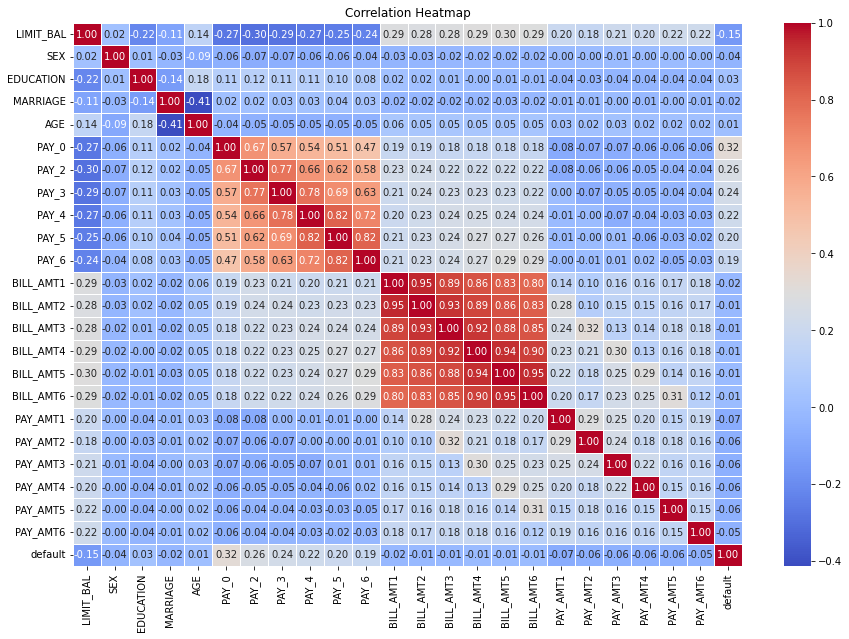

In [11]:
# Plotting correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

#### Distributions

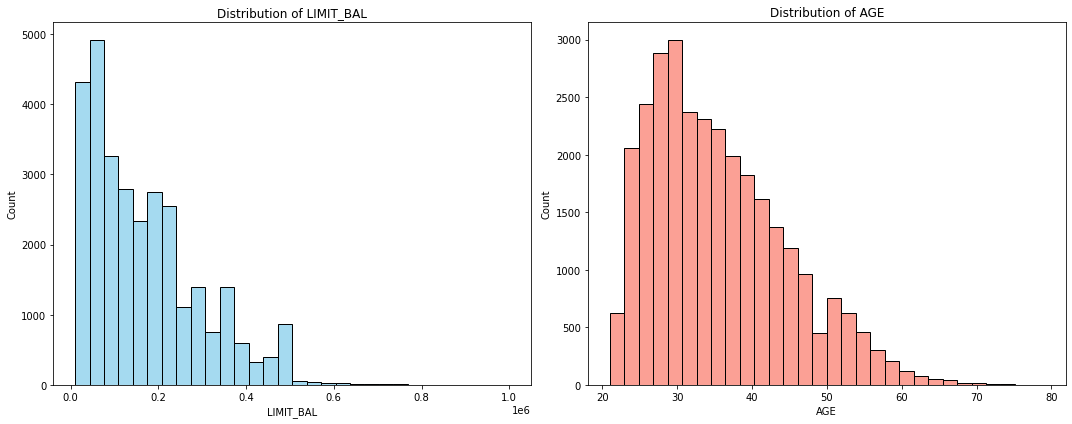

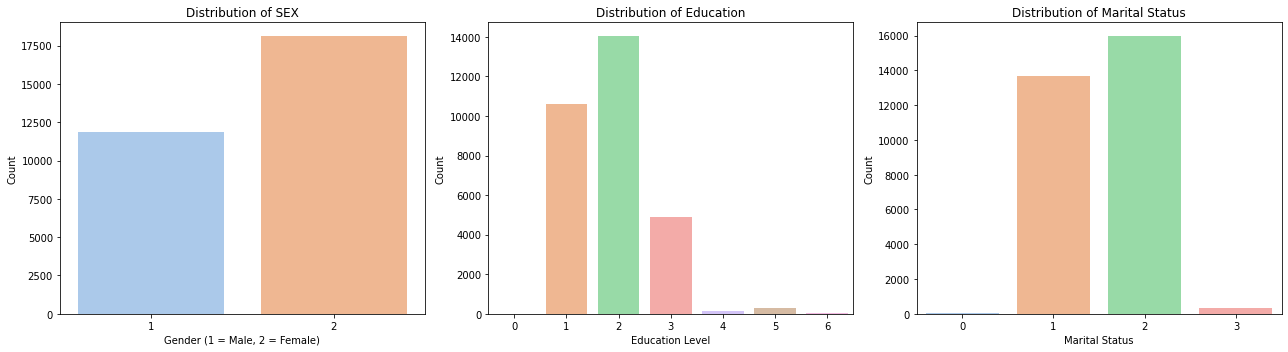

In [12]:
# Plotting distributions for continuous features
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(df[sFeature_analysis_1], bins=30, ax=ax[0], color="skyblue")
ax[0].set_title("Distribution of "+sFeature_analysis_1.upper())
ax[0].set_xlabel(sFeature_analysis_1.upper())
#ax[0].set_xlabel("Credit Limit")
ax[0].set_ylabel("Count")

sns.histplot(df[sFeature_analysis_2], bins=30, ax=ax[1], color="salmon")
ax[1].set_title("Distribution of "+ sFeature_analysis_2.upper())
ax[1].set_xlabel(sFeature_analysis_2.upper())
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# Plotting distributions for categorical features
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(data=df, x=sFeature_analysis_3, ax=ax[0], palette="pastel")
ax[0].set_title("Distribution of " + sFeature_analysis_3.upper())
ax[0].set_xlabel("Gender (1 = Male, 2 = Female)")
ax[0].set_ylabel("Count")

sns.countplot(data=df, x="EDUCATION", ax=ax[1], palette="pastel")
ax[1].set_title("Distribution of Education")
ax[1].set_xlabel("Education Level")
ax[1].set_ylabel("Count")

sns.countplot(data=df, x="MARRIAGE", ax=ax[2], palette="pastel")
ax[2].set_title("Distribution of Marital Status")
ax[2].set_xlabel("Marital Status")
ax[2].set_ylabel("Count")

plt.tight_layout()
plt.show()


# Feature Engineering

## Check for Missing Data

In [13]:
# Determine the threshold for missing values
threshold = 0.75 * len(df)

# Identify columns with missing values greater than the threshold
missing_columns = df.columns[df.isnull().sum() > threshold]

# Print the columns with more than 75% missing values
print("Columns with more than 75% missing values:", missing_columns)

# Drop columns with missing values greater than the threshold
df = df.drop(columns=missing_columns)

# Save or continue processing with columns removed that had high volumes of missing data


Columns with more than 75% missing values: Index([], dtype='object')


In [14]:
# Display the first few rows of the dataset to re-check structure once any columns with 
# significant amounts of missing data have been removed
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Categorical Data 

In [15]:
# List of categorical columns
cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [16]:
# Adjust cat columns to range from 0
# df[cat_cols] = df[cat_cols] = df[cat_cols].apply(LabelEncoder().fit_transform)

In [17]:
# One-hot encode categorical variables
#df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df_encoded = pd.get_dummies(df, columns=cat_cols)

In [18]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [19]:
# Display the first few rows of the dataset to understand its structure
df_encoded.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,20000,24,3913,3102,689,0,0,0,0,689,...,1,0,0,0,0,0,0,0,0,0
1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,...,0,0,0,1,0,0,0,0,0,0
2,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,...,0,0,1,0,0,0,0,0,0,0
3,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,...,0,0,1,0,0,0,0,0,0,0
4,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,...,0,0,1,0,0,0,0,0,0,0


In [20]:
# display all columns
pd.set_option('display.max_columns', None)
print(df_encoded)

       LIMIT_BAL  AGE  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0          20000   24       3913       3102        689          0          0   
1         120000   26       2682       1725       2682       3272       3455   
2          90000   34      29239      14027      13559      14331      14948   
3          50000   37      46990      48233      49291      28314      28959   
4          50000   57       8617       5670      35835      20940      19146   
...          ...  ...        ...        ...        ...        ...        ...   
29995     220000   39     188948     192815     208365      88004      31237   
29996     150000   43       1683       1828       3502       8979       5190   
29997      30000   37       3565       3356       2758      20878      20582   
29998      80000   41      -1645      78379      76304      52774      11855   
29999      50000   46      47929      48905      49764      36535      32428   

       BILL_AMT6  PAY_AMT1  PAY_AMT2  P

# Build Model

## Downsample Majority Class

In [21]:
# Check the distribution of the target variable
target_distribution = df_encoded['default'].value_counts()

target_distribution

0    23364
1     6636
Name: default, dtype: int64

In [22]:
# Separate the majority and minority classes
df_majority = df_encoded[df_encoded['default'] == 0]
df_minority = df_encoded[df_encoded['default'] == 1]

In [23]:
# Downsample the majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False, 
                                   n_samples=target_distribution[1], 
                                   random_state=42)

In [24]:
# Combine the downsampled majority class with the minority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [25]:
# Shuffle the dataset to mix the data points
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

## Split Features + Target

In [26]:
# Splitting the features and target variable
X = df_downsampled.drop('default', axis=1)
y = df_downsampled['default']

## Split Data into Test/Training Datasets

In [27]:
# Splitting the dataset into training and testing sets
X_train_downsampled, X_test, y_train_downsampled, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
# Reset Indexes
X_train_downsampled = X_train_downsampled.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train_downsampled = y_train_downsampled.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Training Data Exploration - Post Downsampling

In [29]:
# Train model Stats
print("Number of Features:", X_train_downsampled.shape[1])
print("Number Continuous Features:", X_train_downsampled.shape[1] - len(cat_cols))
print("Number Categorical Features:", len(cat_cols))
print("Number Train Examples:", X_train_downsampled.shape[0])
print("Number Positive Train Examples:", (y_train_downsampled == 1).sum())
print("Number Negative Train Examples:", (y_train_downsampled == 0).sum())

Number of Features: 91
Number Continuous Features: 82
Number Categorical Features: 9
Number Train Examples: 9290
Number Positive Train Examples: 4613
Number Negative Train Examples: 4677


## Apply RF Hyperparameters

In [30]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2,
                           scoring='recall_macro')

grid_search.fit(X_train_downsampled, y_train_downsampled)

# Get the best parameters
best_params = grid_search.best_params_

print(best_params)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


## Train Model

In [31]:
# Set Up Random Forest model
# Train the Random Forest classifier with the best parameters
rf_classifier = RandomForestClassifier(**best_params, random_state=42)
#rf_classifier = RandomForestClassifier(random_state=42)
#rf_classifier.fit(X_train, y_train)

In [32]:
# Set up LGBMClassifier model
lgbm_model = lgb.LGBMClassifier()

In [33]:
# Assign model
model = rf_classifier 
#model = lgbm_model 

In [34]:
# Train chosen model
#model.fit(X_train, y_train)
# Retrain the Random Forest classifier on the downsampled data
model.fit(X_train_downsampled, y_train_downsampled)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, random_state=42)

In [35]:
X_train_downsampled.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,240000,38,7466,221,189,189,1648,1459,899,198,0,1459,0,1250,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,50000,27,49684,45435,37636,32034,28133,23860,1961,2075,1294,999,934,849,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,250000,29,1181,1545,2319,1856,4356,7026,1545,1000,1500,2500,3000,1379,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,50000,23,48784,50371,51400,0,0,0,2400,2400,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,110000,27,102551,103550,105089,107164,105988,108617,5500,6000,6000,4000,5000,4000,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


# Evaluate Model

## Predict on Test Data

In [36]:
# Predict on the test data
y_pred = model.predict(X_test)

## Assess Model Peformance

### Generate Accuracy Metrics

In [37]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

#accuracy, classification_rep, conf_matrix

### Present Table of Metrcis

In [38]:
# Extract metrics directly from the classification_report function in a structured format
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Organize the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'ROC AUC Score', 'Precision (Class 0)', 'Recall (Class 0)', 'F1-Score (Class 0)', 
               'Precision (Class 1)', 'Recall (Class 1)', 'F1-Score (Class 1)'],
    'Value': [accuracy, roc_auc, 
              report_dict['0']['precision'], report_dict['0']['recall'], report_dict['0']['f1-score'],
              report_dict['1']['precision'], report_dict['1']['recall'], report_dict['1']['f1-score']]
})

# Display the dataframe in a tabular format
display(HTML(metrics_df.to_html(index=False, classes="table table-striped table-bordered")))


Metric,Value
Accuracy,0.706429
ROC AUC Score,0.707907
Precision (Class 0),0.668515
Recall (Class 0),0.799898
F1-Score (Class 0),0.728329
Precision (Class 1),0.760684
Recall (Class 1),0.615917
F1-Score (Class 1),0.680688


### Generate Confusion Matrix

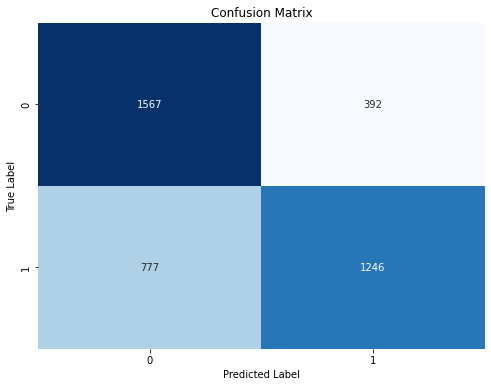

In [39]:
# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate DICE Values

#### Suppress Warnings to clean up output

In [103]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

Check layout of X_train_downsampled

In [104]:
X_train_downsampled.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,240000,38,7466,221,189,189,1648,1459,899,198,0,1459,0,1250,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,50000,27,49684,45435,37636,32034,28133,23860,1961,2075,1294,999,934,849,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,250000,29,1181,1545,2319,1856,4356,7026,1545,1000,1500,2500,3000,1379,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,50000,23,48784,50371,51400,0,0,0,2400,2400,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,110000,27,102551,103550,105089,107164,105988,108617,5500,6000,6000,4000,5000,4000,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


##### ChatGPT Prompt

For the RF model built above in Python, select a random sample 
of 15 instances in the test data, 10 for Class '0' and 5 for 
Class '1', and generate Diverse Counterfactual Explanations (DICE)
as explainers for these instances in the test dataset. Add the 
Diverse Counterfactual Explanations into a dataframe and include 
the associated target ('default') variable value for each instance
row,


Present these DICE explanations in an easily understood and pleasant 
on the eye tabular output format for the Python Kubeflow Notebook
in which I am writing my Python code. 

Also generate these values into an output CSV file.

Comment each line of Python code with as much detail as practical.

After the code generation provide as much narrative detail 
as possible.

##### ChatGPT Output

Certainly! Diverse Counterfactual Explanations (DiCE) is a popular method to generate counterfactual instances for a given instance, showing how slight changes in feature values can lead to different predicted outcomes. This is particularly useful in understanding the decision boundaries of machine learning models and to verify if the model's behavior aligns with domain knowledge or expected outcomes.

Here's the step-by-step approach:

Sample the data: Randomly select 15 instances from the test data - 10 from Class '0' and 5 from Class '1'.

In [105]:
# 1. Sample the data

# Split the test data into two dataframes based on the 'default' value
#class_0_data = X_test[y_test == 0]
#class_1_data = X_test[y_test == 1]

# Randomly sample 10 instances from Class '0' and 5 instances from Class '1'
#sampled_class_0 = class_0_data.sample(n=10, random_state=42)
#sampled_class_1 = class_1_data.sample(n=5, random_state=42)

# Combine the sampled data
#sampled_data = pd.concat([sampled_class_0, sampled_class_1])

In [106]:
# Split the test data (including the 'default' column) into two dataframes based on the 'default' value
class_0_data_with_target = X_test[y_test == 0].copy()
class_0_data_with_target['default'] = 0

class_1_data_with_target = X_test[y_test == 1].copy()
class_1_data_with_target['default'] = 1

# Randomly sample 10 instances from Class '0' and 5 instances from Class '1'
sampled_class_0_with_target = class_0_data_with_target.sample(n=10, random_state=42)
sampled_class_1_with_target = class_1_data_with_target.sample(n=5, random_state=42)

# Combine the sampled data
sampled_data_with_target = pd.concat([sampled_class_0_with_target, sampled_class_1_with_target])

In [107]:
sampled_data = sampled_data_with_target

In [109]:
sampled_data

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,default
2339,180000,34,47517,26137,18177,16866,15067,7615,1526,3006,5020,5000,2000,935,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1179,180000,40,1903,0,0,3155,1173,1021,0,0,3155,1173,1021,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
901,500000,29,2140,3919,3572,2749,2140,3109,3919,3763,2749,2140,3109,2140,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
760,20000,49,8503,11352,10198,10400,1150,0,3008,0,600,1150,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3931,200000,48,2233,6731,1374,24836,23348,7058,6734,1374,74836,0,250,55892,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1944,190000,46,80903,83900,86897,90399,85698,88400,5000,5000,5600,3000,4000,4500,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
245,20000,37,16455,16511,18902,18768,18650,19175,1609,3000,663,676,834,782,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2976,130000,40,20733,14261,22242,18265,21546,32411,7261,12272,10265,11546,12411,10000,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2422,400000,43,398711,407664,186081,189987,193824,201699,17000,7000,7000,7000,11000,10000,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
471,50000,26,49855,51099,51192,50895,19535,20093,4100,3000,3500,1000,1000,1100,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


2: Generate DiCE explanations: 
For each of these instances, generate counterfactual instances using the DiCE library.

The DiCE library requires the model to have a predict function that outputs probabilities. The RandomForest classifier from scikit-learn provides predict_proba for this purpose.

Let's generate the DiCE explanations.

Set up the data object for DiCE:
You need to define which features are continuous and provide the name of the outcome variable.

#### Generate a single Counterfactual

In [146]:
import dice_ml
#d = dice_ml.Data(dataframe=df_encoded, continuous_features=list(X.columns), outcome_name='default')

# Assuming df_encoded is your one-hot encoded dataframe and X is your feature set

# List of original continuous features (excluding one-hot encoded columns)
original_continuous_features = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 
                               'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 
                               'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Setting up the DiCE data object
d = dice_ml.Data(dataframe=df_encoded, continuous_features=original_continuous_features, 
                 outcome_name='default')

Wrap the model for DiCE:
DiCE requires the model to have a certain structure. 
If you're using a scikit-learn model, you can easily wrap it as follows:

In [147]:
backend = 'sklearn'
m = dice_ml.Model(model=model, backend=backend)

Generate counterfactual instances:
For each instance you want to explain, you generate counterfactuals. 
Here's how you can do it for a single instance:

In [148]:
# Create a DiCE explainer object
exp = dice_ml.Dice(d, m)

In [149]:
# Extracting the specific row from the test set
query_df = sampled_data.iloc[[0]]

# Ensuring the column order and format matches df_encoded
query_df = query_df.reindex(columns=df_encoded.columns, fill_value=0)

# Dropping the 'default' column to match the feature set
query_df = query_df.drop(columns='default')

# Now, generate counterfactuals using this DataFrame
dice_exp = exp.generate_counterfactuals(query_df, total_CFs=1, desired_class="opposite")

100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


In [150]:
print(dir(dice_exp))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_cf_examples_list', '_check_cf_exp_output_against_json_schema', '_local_importance', '_metadata', '_summary_importance', '_validate_serialization_version', 'cf_examples_list', 'from_json', 'local_importance', 'metadata', 'summary_importance', 'to_json', 'visualize_as_dataframe', 'visualize_as_list']


#### Visualise a single Counterfactual

In [151]:
# Visualize counterfactual explanation
dice_exp.visualize_as_dataframe()

Query instance (original outcome : 0)


,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,default
0,180000,34,47517,26137,18177,16866,15067,7615,1526,3006,5020,5000,2000,935,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0



Diverse Counterfactual set (new outcome: 1.0)


,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,default
0,180000,34,47517,26137,18177,16866,15067,7615,1526,3006,5020,5000,2000,935,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1


In [152]:
# Assuming the cf_list contains multiple counterfactual examples, let's retrieve the first one
# cf_instance = cf_list[0].final_cfs_df.iloc[0]
cf_instance= dice_exp.cf_examples_list[0].final_cfs_df.iloc[0]

In [153]:
cf_instance

LIMIT_BAL    180000
AGE              34
BILL_AMT1     47517
BILL_AMT2     26137
BILL_AMT3     18177
              ...  
PAY_6_5           0
PAY_6_6           0
PAY_6_7           0
PAY_6_8           0
default           1
Name: 0, Length: 92, dtype: object

In [155]:
query_df

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
2339,180000,34,47517,26137,18177,16866,15067,7615,1526,3006,5020,5000,2000,935,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


#### Identify a single Counterfactual Explanation

In [156]:
def get_differing_columns(original_instance, counterfactual_instance):
    """
    Given an original instance and its counterfactual explanation,
    return the columns where their values differ.
    """
    differing_columns = []
    
    for column in original_instance.index:
        if original_instance[column] != counterfactual_instance[column]:
            differing_columns.append(column)
    
    return differing_columns

In [157]:
# Test the function with a sample instance and its counterfactual
sample_instance = sampled_data.iloc[0, :-1]  # Excluding the 'default' column

In [159]:
import pandas as pd

# Convert the sample_cf list to a pandas Series
sample_cf_series = pd.Series(cf_instance, index=sample_instance.index)

In [160]:
# Now you can use the sample_cf_series with the get_differing_columns function:
differing_columns_sample = get_differing_columns(sample_instance, sample_cf_series)
#differing_columns_sample = get_differing_columns(sample_instance, cf_instance)

In [161]:
differing_columns_sample
#print(differing_columns_sample)

['PAY_0_2', 'PAY_6_3']

In [119]:
# Save generated counterfactual examples to disk
dice_exp.cf_examples_list[0].final_cfs_df.to_csv(path_or_buf='ind_counterfactuals.csv', index=False)

In [120]:
#sampled_data['default']

#### Generate Multiple Counterfactuals

In [121]:
# List to store counterfactual instances
counterfactuals = []

# Loop through all the instances in the sampled_data DataFrame
for index in sampled_data.index:
    
    # Extracting the specific row from the test set as a DataFrame
    query_df = sampled_data.loc[[index]]
    
    # Ensuring the column order and format matches df_encoded
    query_df = query_df.reindex(columns=df_encoded.columns, fill_value=0)
    
    # Dropping the 'default' column to match the feature set
    query_df = query_df.drop(columns='default')
    
    # Generate counterfactuals using this DataFrame
    dice_exp = exp.generate_counterfactuals(query_df, total_CFs=1, desired_class="opposite")
    
    # Retrieve the counterfactual instance using the correct attribute
    cf_instance = dice_exp.cf_examples_list[0].final_cfs_df.iloc[0]
    
    # Append the counterfactual instance to the counterfactuals list
    counterfactuals.append(cf_instance)

100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


In [122]:
# Convert the list of counterfactual instances into a DataFrame
cf_df = pd.DataFrame(counterfactuals)
cf_df['default_orig'] = y_test[sampled_data.index].values

In [127]:
cf_df

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,default,default_orig
0,180000,34,47517,26137,18177,16866,15067,7615,1526,3006,5020,5000,2000,935,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
0,180000,40,1903,0,0,3155,1173,1021,0,0,3155,1173,1021,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
0,500000,29,2140,608801,3572,2749,2140,3109,3919,3763,2749,2140,3109,2140,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
0,20000,49,8503,11352,10198,10400,1150,0,3008,0,600,543711,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
0,200000,48,2233,6731,1374,24836,23348,7058,6734,1374,74836,0,250,55892,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
0,190000,46,80903,83900,86897,90399,85698,88400,5000,5000,5600,3000,4000,4500,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
0,20000,37,16455,16511,18902,18768,18650,19175,1609,3000,663,676,834,782,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
0,130000,40,20733,14261,22242,18265,21546,32411,7261,12272,10265,11546,12411,10000,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
0,400000,43,398711,407664,186081,189987,193824,201699,17000,7000,7000,7000,11000,10000,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
0,50000,26,49855,51099,51192,50895,19535,20093,4100,3000,3500,1000,1000,1100,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [130]:
DICE_explainers_filepath = "DICE_explainers.csv"
cf_df.to_csv(DICE_explainers_filepath, index=False)

Why when I look at the list of random counterfactual explanations do some of the instances show the same target values as the original feature instance?

If you're observing that some of the counterfactual explanations have the same target values as the original feature instances, 
it could be due to a few reasons:

1. Model Confidence: The model might be very confident about its prediction for certain instances, such that small changes in the feature values (as proposed by DiCE) might not be sufficient to change the model's prediction. 
This can result in counterfactual explanations that have the same predicted outcome as the original instance.

2. Constraints on Features: DiCE tries to find the smallest changes in the feature values that would lead to a different prediction. If the changes required are too large (beyond what DiCE considers reasonable), it might not be able to find a suitable counterfactual. 
This can result in counterfactuals that are essentially the same as the original instance.

3. DiCE Parameters: DiCE has several parameters like total_CFs, proximity_weight, and diversity_weight that control the generation of counterfactual explanations. If these are not tuned appropriately, 
the resulting counterfactuals might not always be diverse or might not always flip the prediction.

4. Model Complexity: Complex models like deep neural networks or ensemble methods might have intricate decision boundaries that make it challenging to find counterfactuals. If the model doesn't change its prediction despite reasonable changes in feature values, 
the counterfactual might end up having the same prediction as the original instance.

To address this:

Adjust DiCE Parameters: You can try adjusting parameters like proximity_weight (which controls the closeness of the counterfactual to the original instance) or increasing total_CFs (to generate more diverse counterfactuals). 
This might help in finding counterfactuals that flip the prediction.

Check Model Predictions: It might be beneficial to explicitly check the model's predictions on the counterfactuals and compare them to the original instances. If they're consistently the same, 
it could indicate an issue with the model or the counterfactual generation process.

Diverse Counterfactuals: DiCE also offers the ability to generate multiple diverse counterfactuals for a 
given instance. By generating more counterfactuals per instance, 
you increase the chances of finding one that flips the prediction.

It's important to understand that the goal of counterfactual explanations is not always to flip the 
model's prediction but to provide instances that are close to the original and, when possible, lead to different predictions. 
Sometimes, the model's decision boundary might be such that small perturbations don't change the outcome.